<div class="alert alert-block alert-success">
<h3><center style="line-height: 1">MSDS-422: Practical Machine Learning</center></h3>
<h1><center style="line-height: 1">Final Project: Group 5</center></h1>
<h2><center style="line-height: 1">Identifying Malware in Network Traffic with Supervised Learning</center></h2>

<b>Group 5</b>:
<ul>
    <li>Aishwarya Mathuria</li>
    <li>Tanmay Swami</li>
    <li>Akshaya Venkat Raman</li>
    <li>Yatika Taneja</li>
</ul>
</div>

In [46]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import glob
from datetime import datetime
import ipaddress
from collections import Counter
from scipy import stats
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import time

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Load Dataset</h1>
</div>

In [47]:
# Load all CSV files without any cleaning
print("Loading raw data")
csv_files = glob.glob('data/*.csv')
print(f"Found {len(csv_files)} CSV files:")
for file in sorted(csv_files):
    size_mb = Path(file).stat().st_size / (1024 * 1024)
    print(f"  - {file}: {size_mb:.2f} MB")

all_dataframes = []

for file in csv_files:
    try:
        print(f"Loading {file}...")
        df = pd.read_csv(file, sep='|')
        all_dataframes.append(df)
        print(f"  - Loaded {len(df)} records")
    except Exception as e:
        print(f"Error loading {file}: {e}")

if not all_dataframes:
    raise ValueError("No data files could be loaded")

df = pd.concat(all_dataframes, ignore_index=True)
print(f"\nCombined raw dataset shape: {df.shape}")

# Combine label and detailed-label
df['label'] = df['label'].astype(str)
df['detailed-label'] = df['detailed-label'].astype(str)
df['detailed-label'].replace('nan', pd.NA, inplace=True)
combined = df['label'] + ' ' + df['detailed-label']
df['label'] = combined.where(
    (df['label'] != 'Benign') & df['detailed-label'].notna(),
    df['label'])
df['label'] = df['label'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Drop detailed-label column
if 'detailed-label' in df.columns:
    df.drop(columns=['detailed-label'], inplace=True)
df.replace('-', pd.NA, inplace=True)

Loading raw data
Found 12 CSV files:
  - data/CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv: 132.06 MB
  - data/CTU-IoT-Malware-Capture-20-1conn.log.labeled.csv: 0.39 MB
  - data/CTU-IoT-Malware-Capture-21-1conn.log.labeled.csv: 0.40 MB
  - data/CTU-IoT-Malware-Capture-3-1conn.log.labeled.csv: 22.09 MB
  - data/CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv: 2.85 MB
  - data/CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv: 1243.76 MB
  - data/CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv: 0.54 MB
  - data/CTU-IoT-Malware-Capture-44-1conn.log.labeled.csv: 0.03 MB
  - data/CTU-IoT-Malware-Capture-48-1conn.log.labeled.csv: 498.91 MB
  - data/CTU-IoT-Malware-Capture-60-1conn.log.labeled.csv: 442.23 MB
  - data/CTU-IoT-Malware-Capture-8-1conn.log.labeled.csv: 1.27 MB
  - data/CTU-IoT-Malware-Capture-9-1conn.log.labeled.csv: 886.22 MB
Loading data/CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv...
  - Loaded 10447787 records
Loading data/CTU-IoT-Malware-Capture-3-1conn.log.labeled.c

In [48]:
print("\nUpdated label distribution:")
print(df['label'].value_counts())


Updated label distribution:
label
Malicious PartOfAHorizontalPortScan        10427048
Benign                                      8780158
Malicious DDoS                              5778154
Malicious C&C                                 15039
Malicious Attack                               8717
Malicious C&C HeartBeat                         940
Malicious C&C PartOfAHorizontalPortScan         888
Malicious C&C Torii                              30
Malicious C&C FileDownload                       26
Malicious FileDownload                            3
Name: count, dtype: int64


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Exploratory Data Analysis</h1>
</div>

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Basic dataset Information</h3>
</div>

In [49]:
print("\n")
print(f"Total records: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"Shape: {df.shape}")
df.info(memory_usage='deep')
print("\n")



Total records: 25011003
Total columns: 22
Shape: (25011003, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25011003 entries, 0 to 25011002
Data columns (total 22 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ts              float64
 1   uid             object 
 2   id.orig_h       object 
 3   id.orig_p       float64
 4   id.resp_h       object 
 5   id.resp_p       float64
 6   proto           object 
 7   service         object 
 8   duration        object 
 9   orig_bytes      object 
 10  resp_bytes      object 
 11  conn_state      object 
 12  local_orig      object 
 13  local_resp      object 
 14  missed_bytes    float64
 15  history         object 
 16  orig_pkts       float64
 17  orig_ip_bytes   float64
 18  resp_pkts       float64
 19  resp_ip_bytes   float64
 20  tunnel_parents  object 
 21  label           object 
dtypes: float64(8), object(14)
memory usage: 22.5 GB




In [50]:
numeric_cols = ['duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [51]:
# Dropping some insignificant columns based on the value information
dropCols = ['uid', 'tunnel_parents', 'local_orig', 'local_resp', 'service', 'history', 'id.orig_h', 'id.resp_h', 'id.orig_h', 'id.resp_h']
df = df.drop(columns=dropCols)

In [52]:
df.head()

,ts,id.orig_p,id.resp_p,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,1.545403e+09,59932.0,80.0,tcp,3.097754,0.0,0.0,S0,0.0,3.0,180.0,0.0,0.0,Malicious C&C
1,1.545403e+09,59932.0,80.0,tcp,NaN,NaN,NaN,S0,0.0,1.0,60.0,0.0,0.0,Malicious C&C
2,1.545403e+09,59932.0,80.0,tcp,NaN,NaN,NaN,S0,0.0,1.0,60.0,0.0,0.0,Malicious C&C
3,1.545403e+09,35883.0,53.0,udp,5.005148,78.0,0.0,S0,0.0,2.0,134.0,0.0,0.0,Benign
4,1.545403e+09,43531.0,53.0,udp,5.005145,78.0,0.0,S0,0.0,2.0,134.0,0.0,0.0,Benign


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Columns</h3>
</div>

In [53]:
print("Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

Columns:
    1. ts
    2. id.orig_p
    3. id.resp_p
    4. proto
    5. duration
    6. orig_bytes
    7. resp_bytes
    8. conn_state
    9. missed_bytes
   10. orig_pkts
   11. orig_ip_bytes
   12. resp_pkts
   13. resp_ip_bytes
   14. label


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Data types</h3>
</div>

In [54]:
print(df.dtypes.value_counts())

float64    11
object      3
Name: count, dtype: int64


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Missing values</h3>
</div>

,MissingValues,Percent
duration,15272073,61.06
orig_bytes,15272073,61.06
resp_bytes,15272073,61.06


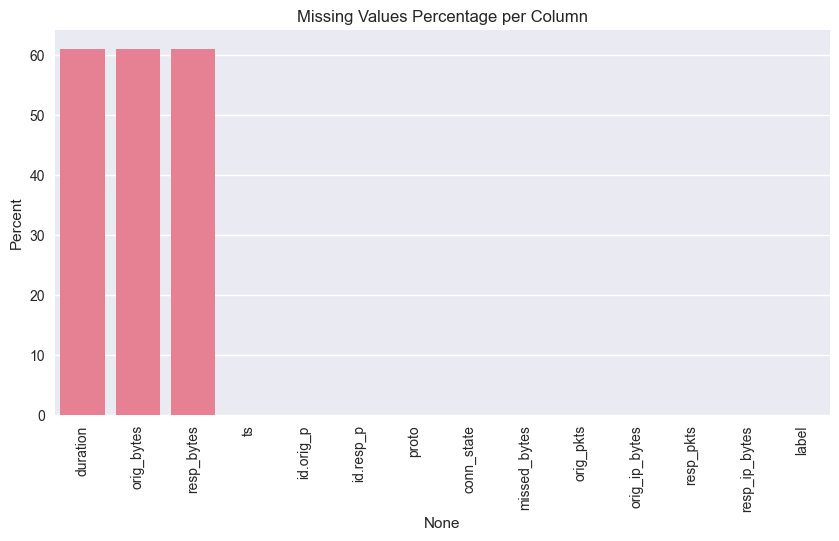

In [55]:
# Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({'MissingValues': missing, 'Percent': missing_percent})
display(missing_df[missing_df.MissingValues > 0])

# Visualize missing values
plt.figure(figsize=(10,5))
sns.barplot(x=missing_df.index, y=missing_df['Percent'])
plt.xticks(rotation=90)
plt.title("Missing Values Percentage per Column")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Target value Distribution</h3>
</div>

label
Malicious PartOfAHorizontalPortScan        10427048
Benign                                      8780158
Malicious DDoS                              5778154
Malicious C&C                                 15039
Malicious Attack                               8717
Malicious C&C HeartBeat                         940
Malicious C&C PartOfAHorizontalPortScan         888
Malicious C&C Torii                              30
Malicious C&C FileDownload                       26
Malicious FileDownload                            3
Name: count, dtype: int64


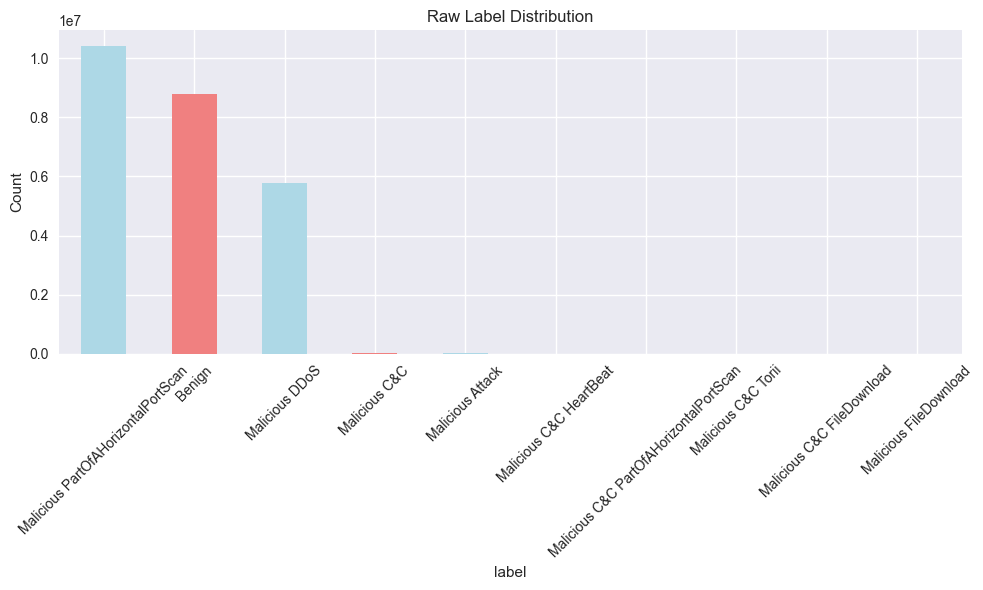

In [56]:
label_counts = df['label'].value_counts()
print(label_counts)

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Raw Label Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Histograms for numerical features</h3>
</div>

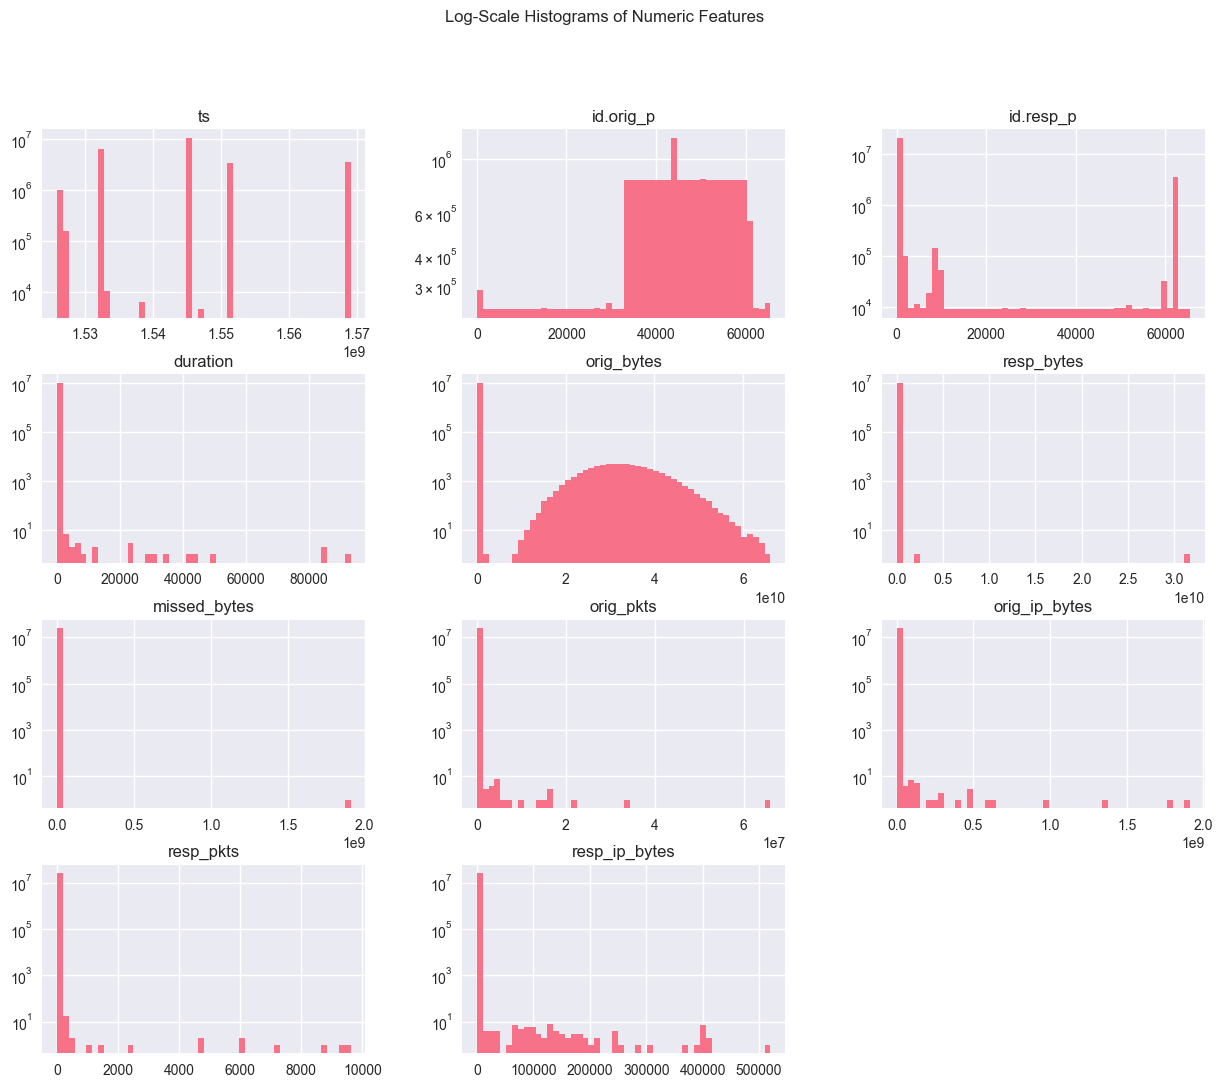

In [57]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(figsize=(15, 12), bins=50, log=True)
plt.suptitle("Log-Scale Histograms of Numeric Features")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Correlation Heatmap</h3>
</div>

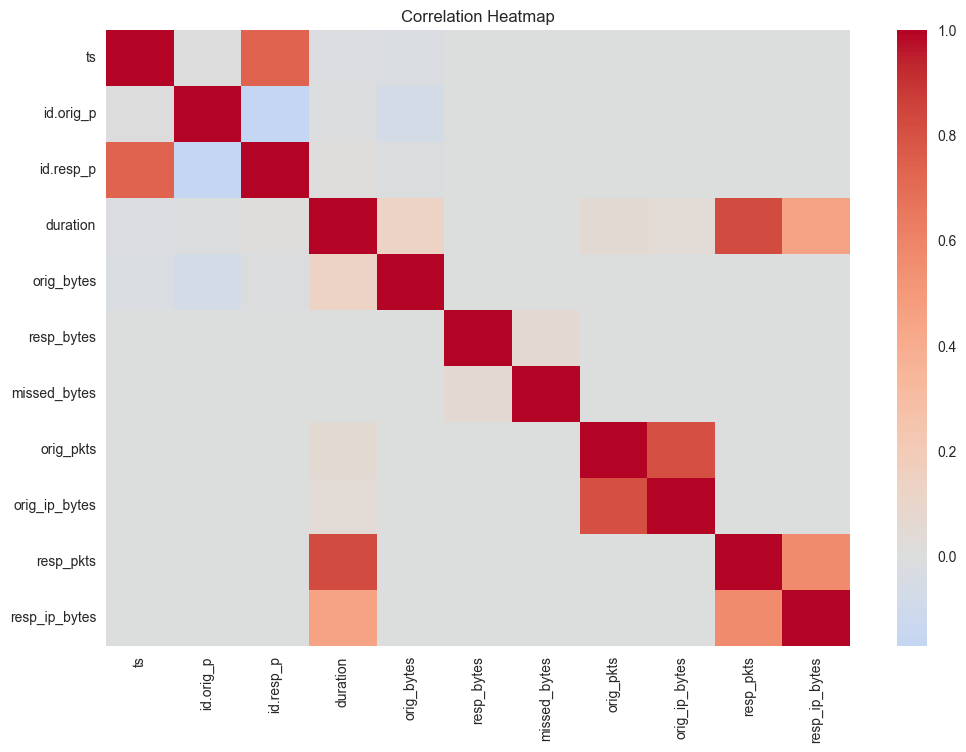

In [58]:
plt.figure(figsize=(12,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Boxplots by Label</h3>
</div>

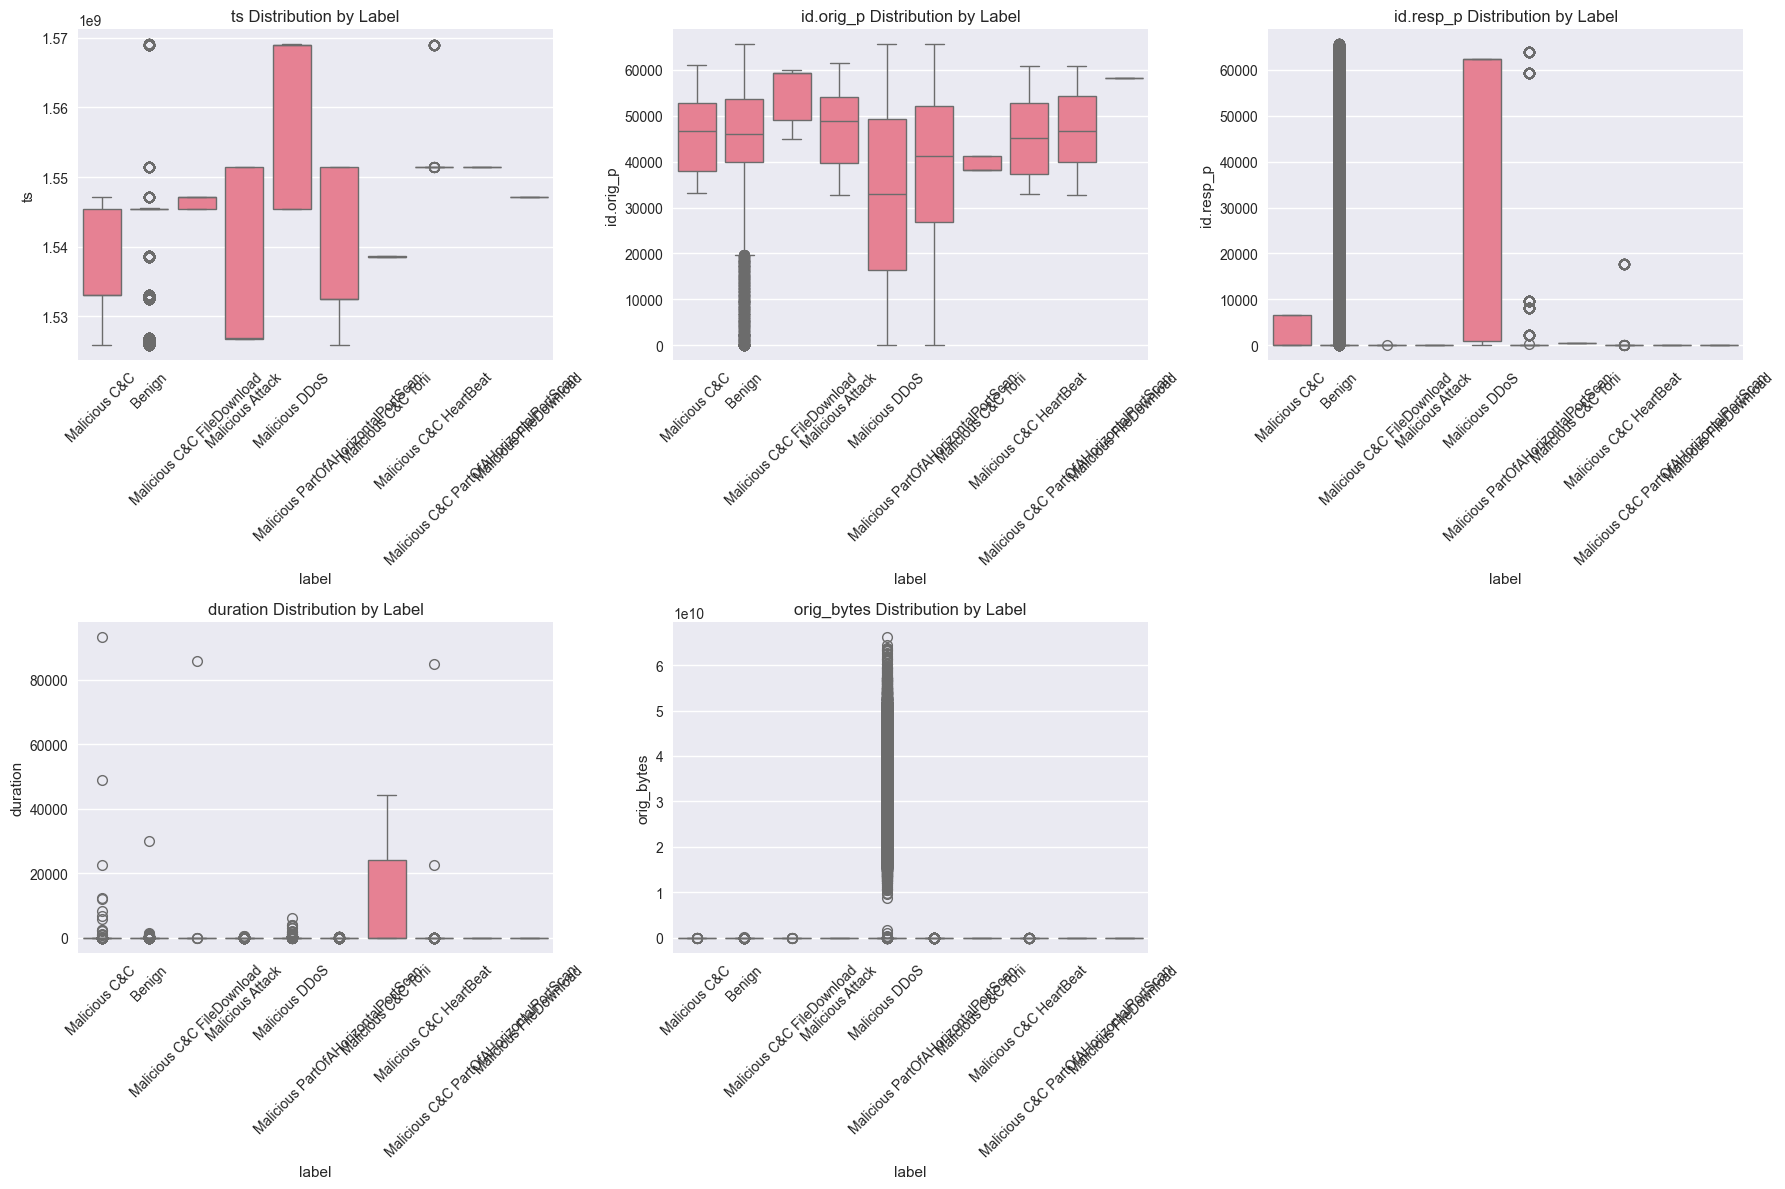

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:5]):  # first 5 numeric features
    sns.boxplot(x='label', y=col, data=df, ax=axes[i])
    axes[i].set_title(f"{col} Distribution by Label")
    axes[i].tick_params(axis='x', rotation=45)

axes[5].set_visible(False)

plt.tight_layout()
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Outlier detection</h3>
</div>

In [60]:
for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_count = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outlier_count} outliers")


ts: 0 outliers
id.orig_p: 769075 outliers
id.resp_p: 5344827 outliers
duration: 3466067 outliers
orig_bytes: 120087 outliers
resp_bytes: 36007 outliers
missed_bytes: 43 outliers
orig_pkts: 180286 outliers
orig_ip_bytes: 93152 outliers
resp_pkts: 54629 outliers
resp_ip_bytes: 54629 outliers


<div style="background: #e6e6fa; border: 1px solid rgb(123, 123, 226); padding: 10px 20px">
    <h2>Exploratory Data Analysis Observation</h2>
    <h3>1. Target variable</h3>
    <p>
        There are 2 level label columns available - <strong>“label”</strong> and <strong>“detailed-label”</strong>. The two have been concatenated into a single field <strong>"label"</strong> to create a multi class prediction model.
    </p>
    <h3>2. Missing Data Patterns</h3>
    <ul>
        <li><strong>Critical Finding:</strong> 61.06% missing values in duration, orig_bytes, and resp_bytes (15,272,073 records)</li>
        <li>This pattern likely indicates <strong>incomplete network connections</strong> - potentially scanning attempts or failed connections</li>
        <li>Missing data distribution suggests systematic patterns rather than random occurrence</li>
    </ul>
    <h3>3. Network Traffic Characteristics</h3>
    <ul>
        <li><strong>TCP</strong> and <strong>UDP</strong> protocols are dominant with distinct behavioral patterns</li>
        <li>There is a mix of well-known ports (0-1023), registered ports (1024-49151), and dynamic ports (49152-65535). There is a potential to group this into more genric terms.</li>
        <li>Various connection states including <strong>S0 (rejected), SF (normal),</strong> indicating different connection behaviors</li>
        <li>Traffic distributed across hours and days, revealing potential attack timing signatures</li>
    </ul>
    <h3>4. Data Quality Assessment</h3>
    <ul>
        <li>There are no negative values detected in numerical columns indicating good data integrity</li>
        <li>Significant outliers are present in network metrics, requiring careful handling</li>
        <li>There is a strong relationships between traffic volume metrics and packet counts</li>
        <li>Multi class classification between <strong>'Benign', 'Malicious C&C' etc.</strong> for traffic will be required.</li>
    </ul>
    <h3>5. Feature Engineering Opportunities</h3>
    <ul>
        <li>Timestamps can be used to engineer more generic and significant features like hour and day_of_week to classify network patterns.</li>
        <li>Creating meaningful port categories for behavioral analysis can help get a more generic prediction model.</li>
        <li>Identified potential for ratio-based features (bytes per packet, packets per second) that can act as a strong features for prediction.</li>
        <li>High missing rates may serve as strong predictive features</li>
    </ul>
    <h3>6. Implications for Model Development</h3>
    <ul>
        <li>Missing value patterns appear to be <strong>highly indicative of malicious behavior</strong></li>
        <li>Feature engineering can be used to convert some values like timestamp, packet info into a more significant predicion features.</li>
        <li>There are a lot of categorical columns that can be properly encoded to ensure optimal model performance</li>
    </ul>
</div>

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Data Cleaning and Preparation</h1>
</div>

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling missing values</h3>
</div>

In [61]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

In [62]:
for col in numeric_cols:
    if col in df.columns:
        print(f"Converting {col} to numeric...")
        df[col] = pd.to_numeric(df[col], errors='coerce')
        missing_before = df[col].isnull().sum()
        df[col] = df[col].fillna(0)
        missing_after = df[col].isnull().sum()
        print(f"    Missing values: {missing_before} -> {missing_after}")

Converting ts to numeric...
    Missing values: 0 -> 0
Converting id.orig_p to numeric...
    Missing values: 0 -> 0
Converting id.resp_p to numeric...
    Missing values: 0 -> 0
Converting duration to numeric...
    Missing values: 15272073 -> 0
Converting orig_bytes to numeric...
    Missing values: 15272073 -> 0
Converting resp_bytes to numeric...
    Missing values: 15272073 -> 0
Converting missed_bytes to numeric...
    Missing values: 0 -> 0
Converting orig_pkts to numeric...
    Missing values: 0 -> 0
Converting orig_ip_bytes to numeric...
    Missing values: 0 -> 0
Converting resp_pkts to numeric...
    Missing values: 0 -> 0
Converting resp_ip_bytes to numeric...
    Missing values: 0 -> 0


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Feature Engineering</h3>
    <p>To uncover hidden behavioral patterns in network traffic that raw totals (bytes, packets, duration) cannot show, we will be enngineering features BytesPerPacket and PacketsPerSecond reveal packet size anomalies and traffic burst intensity for better attack detection.</p>
</div>

In [63]:
df['TotalBytes'] = df['orig_bytes'].fillna(0) + df['resp_bytes'].fillna(0)
df['TotalPackets'] = df['orig_pkts'].fillna(0) + df['resp_pkts'].fillna(0)

df['bytes_per_pkt'] = np.where(df['TotalPackets'] > 0, df['TotalBytes'] / df['TotalPackets'], 0)
df['pkt_per_sec'] = np.where(df['duration'] > 0, df['TotalPackets'] / df['duration'], 0)

df.drop(['TotalBytes', 'TotalPackets'], axis=1, inplace=True)

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Convert timestamp to better fearure components</h3>
    <p>Since timestamp is a very uique typr of feature that will not add much value to the overall prediction, we cannot use that. However, the information about the time of day and day of week the attack happened will be helpful predictors. We will be adding hour and day_of_week features to create strong predictors out of this.</p>
</div>

In [64]:
print("Converting timestamps")
df['timestamp'] = pd.to_datetime(df['ts'], unit='s', errors='coerce')
invalid_timestamps = df['timestamp'].isnull().sum()
print(f"    Invalid timestamps: {invalid_timestamps}")

# Adding temporal features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
print("Added hour and day_of_week features")

Converting timestamps
    Invalid timestamps: 0
Added hour and day_of_week features


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling connection ports</h3>
    <p>We will categorize origin and response ports into well_known (0–1024), registered (1025–49151), and dynamic (49152–65535) ranges to transform raw port numbers into meaningful service categories. This is done because raw port values are high-cardinality and difficult for models to interpret directly, while grouped categories reveal the purpose and behavior of traffic—for example, repeated connections on well-known ports may indicate scanning, while unusual activity on dynamic ports could suggest malicious use. By converting ports into these categories, we simplify feature space, reduce noise, and make it easier for machine learning models to detect patterns of attacks and abnormal network behaviors.</p>
</div>

In [65]:
# Categorize ports into common service types
def categorize_port(port):
    try:
        port = int(port)
        if port <= 1024:
            return 'well_known'
        elif port <= 49151:
            return 'registered'
        else:
            return 'dynamic'
    except:
        return 'unknown'

print("Categorizing origin ports...")
df['orig_port_category'] = df['id.orig_p'].apply(categorize_port)
    
print("Categorizing response ports...")
df['resp_port_category'] = df['id.resp_p'].apply(categorize_port)

Categorizing origin ports...
Categorizing response ports...


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling duplicates</h3>
</div>

In [66]:
duplicates_before = df.duplicated().sum()
df = df.drop_duplicates()
duplicates_after = df.duplicated().sum()
print(f"Removed {duplicates_before - duplicates_after} duplicate rows")

Removed 0 duplicate rows


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Drop insignificant columns and high cardinality columns</h3>
</div>

In [67]:
df.columns

Index(['ts', 'id.orig_p', 'id.resp_p', 'proto', 'duration', 'orig_bytes',
       'resp_bytes', 'conn_state', 'missed_bytes', 'orig_pkts',
       'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'label', 'bytes_per_pkt',
       'pkt_per_sec', 'timestamp', 'hour', 'day_of_week', 'orig_port_category',
       'resp_port_category'],
      dtype='object')

In [68]:
cols_to_drop = []
for col in df.columns:
    if df[col].nunique() < 2:
        cols_to_drop.append(col)
    elif df[col].nunique() == len(df):
        cols_to_drop.append(col)
print(cols_to_drop)
df.drop(columns=cols_to_drop, inplace=True)

['ts', 'timestamp']


In [69]:
categorical_cols = df.drop(columns= 'label').select_dtypes(include=['object']).columns

print(df.select_dtypes(exclude=['object']).columns.tolist())
print("-" * 20)
print(categorical_cols)

['id.orig_p', 'id.resp_p', 'duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'bytes_per_pkt', 'pkt_per_sec', 'hour']
--------------------
Index(['proto', 'conn_state', 'day_of_week', 'orig_port_category',
       'resp_port_category'],
      dtype='object')


In [70]:
df[df.select_dtypes(exclude=['object']).columns.tolist() + list(categorical_cols)].head()

,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,bytes_per_pkt,pkt_per_sec,hour,proto,conn_state,day_of_week,orig_port_category,resp_port_category
0,59932.0,80.0,3.097754,0.0,0.0,0.0,3.0,180.0,0.0,0.0,0.0,0.968444,14,tcp,S0,Friday,dynamic,well_known
1,59932.0,80.0,0.000000,0.0,0.0,0.0,1.0,60.0,0.0,0.0,0.0,0.000000,14,tcp,S0,Friday,dynamic,well_known
2,59932.0,80.0,0.000000,0.0,0.0,0.0,1.0,60.0,0.0,0.0,0.0,0.000000,14,tcp,S0,Friday,dynamic,well_known
3,35883.0,53.0,5.005148,78.0,0.0,0.0,2.0,134.0,0.0,0.0,39.0,0.399589,14,udp,S0,Friday,registered,well_known
4,43531.0,53.0,5.005145,78.0,0.0,0.0,2.0,134.0,0.0,0.0,39.0,0.399589,14,udp,S0,Friday,registered,well_known


In [71]:
for col in df[categorical_cols]:
    print(f"{col}: {df[col].nunique()} unique values : {df[col].unique()[:5]}...")

proto: 3 unique values : ['tcp' 'udp' 'icmp']...
conn_state: 13 unique values : ['S0' 'SF' 'REJ' 'OTH' 'RSTO']...
day_of_week: 7 unique values : ['Friday' 'Saturday' 'Sunday' 'Monday' 'Wednesday']...
orig_port_category: 3 unique values : ['dynamic' 'registered' 'well_known']...
resp_port_category: 3 unique values : ['well_known' 'dynamic' 'registered']...


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Visualizing engineered and existing categorical columns</h3>
</div>

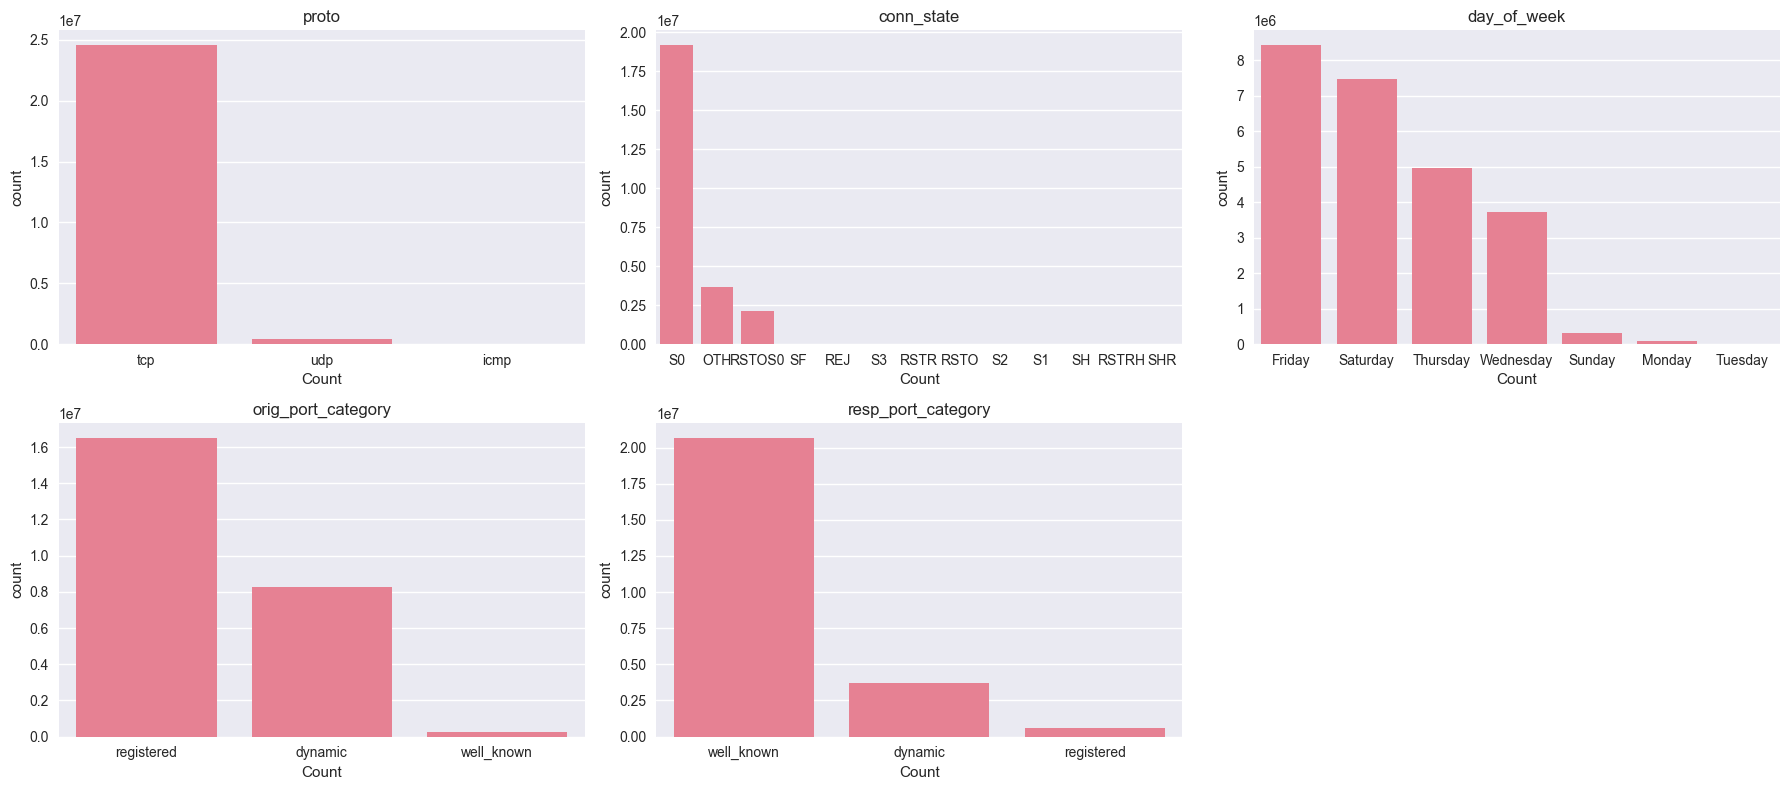

In [72]:
cat_cols = ['proto', 'conn_state', 'day_of_week', 'orig_port_category', 'resp_port_category']

n_cols = 3  
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(6*n_cols, 4*n_rows))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    if col == 'history':
        top_hist = df[col].value_counts().nlargest(20).index
        plot_data = df[df[col].isin(top_hist)]
        sns.countplot(y=col, data=plot_data, order=top_hist)
        plt.title(f"{col} (Top 20)")
    else:
        sns.countplot(x=col, data=df, order=df[col].value_counts().index)
        plt.title(col)
    plt.xlabel("Count")
    plt.tight_layout()

plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Label Encoding</h3>
</div>

In [73]:
encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le
    print(f"Encoded column '{col}' with {len(le.classes_)} classes")

Encoded column 'proto' with 3 classes
Encoded column 'conn_state' with 13 classes
Encoded column 'label' with 10 classes
Encoded column 'day_of_week' with 7 classes
Encoded column 'orig_port_category' with 3 classes
Encoded column 'resp_port_category' with 3 classes


<div style="background: #e6e6fa; border: 1px solid rgb(123, 123, 226); padding: 10px 20px">
    <h2>Data Cleaning and Preparation Observations</h2>
    <h3>1. Feature Engineering</h3>
    <ul>
        <li>Extracted <strong>hour</strong> and <strong>day_of_week</strong> from timestamp for predicting behavioral patterns in network traffic</li>
        <li>Classified ports into <strong>well_known (0-1023), registered (1024-49151), and dynamic (49152-65535)</strong> categories</li>
        <li>Use feature engineering to more generic features for better prediction.</li>
        <li>Filled NaN values with 0, preserving the informative pattern of missingness</li>
    </ul>
    <h3>2. Categorical Data Observations</h3>
    <ul>
        <li>From the visuals, <strong>TCP</strong> and <strong>UDP</strong> dominate the traffic patterns with distinct characteristics</li>
        <li><strong>S0</strong> (rejected connections) prevalent, indicating potential scanning/attack behavior</li>
        <li>Traffic distributed across different <strong>hours</strong> and <strong>days of week</strong> created via feature engineering is giving a good prediction criteria.</li>
        <li>There is a balanced distribution across well-known, registered, and dynamic port ranges</li>
    </ul>
    <h3>3. Label Encoding Results</h3>
    <ul>
        <li>All categorical columns successfully transformed to numerical format for making them part of prediction.</li>
        <li>Maintained original categorical relationships through systematic encoding</li>
        <li>Dataset is now compatible with machine learning algorithms requiring numerical input</li>
        <li>Preserved encoders for potential inverse transformation and model deployment</li>
    </ul>
    <h3>4. Data Quality Validation</h3>
    <ul>
        <li>Successfully eliminated all missing values through strategic imputation</li>
        <li>Confirmed absence of negative values in numerical columns</li>
        <li>Maintained original data relationships while preparing for modeling</li>
        <li>All features now in appropriate format for analysis and modeling</li>
    </ul>
</div>

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Post Cleanup Analysis and Processing</h1>
</div>

In [74]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Missing Values</h3>
</div>

In [75]:
missing_after = df.isnull().sum()
print("Missing values after cleanup:")
print(missing_after[missing_after > 0])

Missing values after cleanup:
Series([], dtype: int64)


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Negative values check</h3>
</div>

In [76]:
for col in numeric_cols:
    if col in df.columns:
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            print(f"{col}: {negative_count} negative values")
        else:
            print(f"{col}: No negative values")

id.orig_p: No negative values
id.resp_p: No negative values
proto: No negative values
duration: No negative values
orig_bytes: No negative values
resp_bytes: No negative values
conn_state: No negative values
missed_bytes: No negative values
orig_pkts: No negative values
orig_ip_bytes: No negative values
resp_pkts: No negative values
resp_ip_bytes: No negative values
label: No negative values
bytes_per_pkt: No negative values
pkt_per_sec: No negative values
day_of_week: No negative values
orig_port_category: No negative values
resp_port_category: No negative values


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Target value distribution</h3>
</div>

label
9    10427048
0     8780158
7     5778154
2       15039
1        8717
4         940
5         888
6          30
3          26
8           3
Name: count, dtype: int64


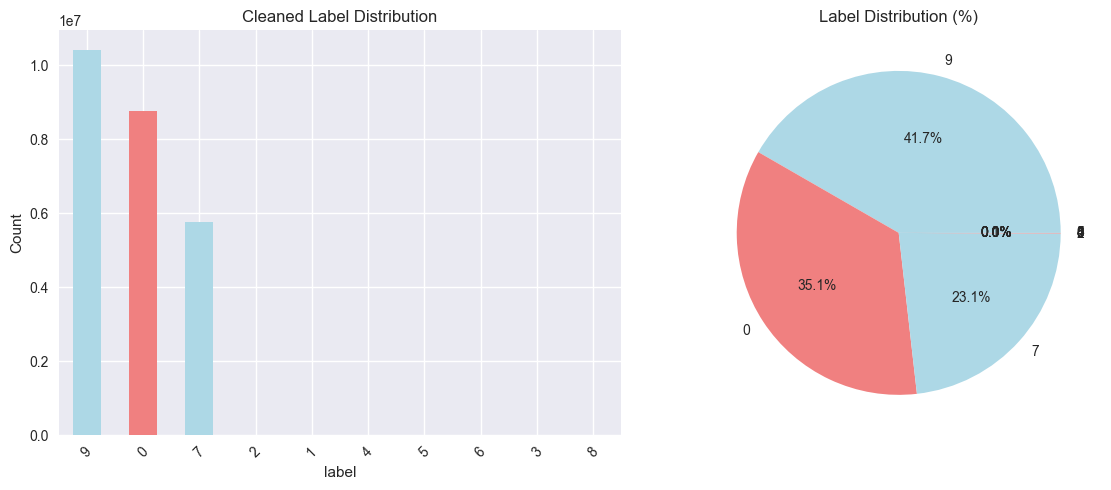

Class imbalance ratio: 0.00


In [77]:
label_counts = df['label'].value_counts()
print(label_counts)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
label_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Cleaned Label Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
        colors=['lightblue', 'lightcoral'])
plt.title('Label Distribution (%)')
plt.tight_layout()
plt.savefig('cleaned_label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Class imbalance ratio: {label_counts[1] / label_counts[0]:.2f}")

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Correlation analysis</h3>
</div>

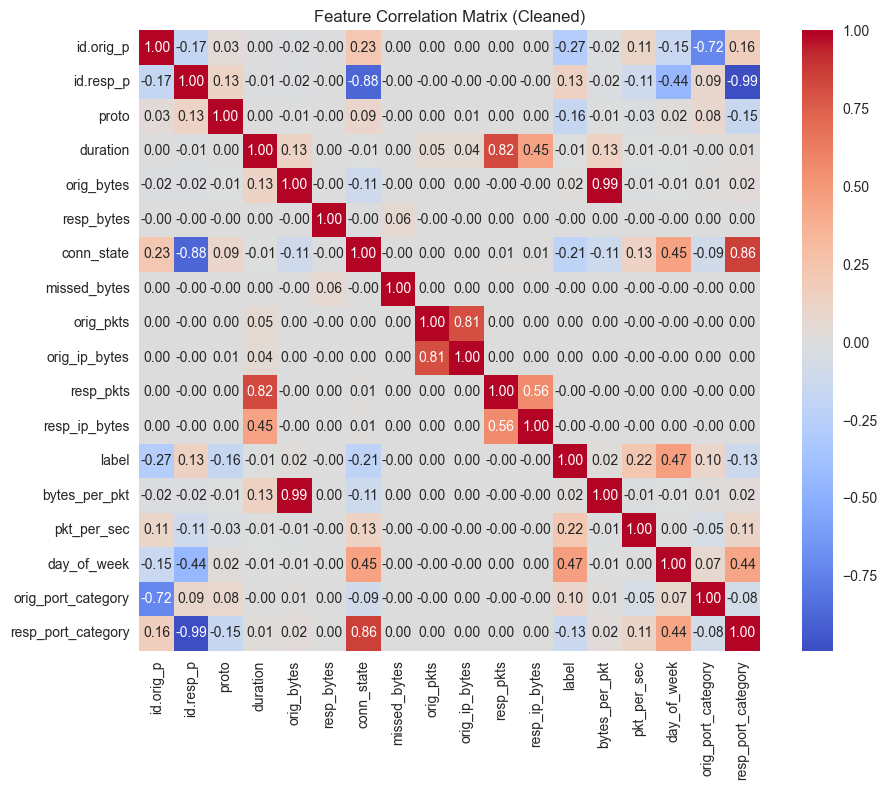

In [79]:
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Feature Correlation Matrix (Cleaned)')
plt.tight_layout()
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Scaling and Train-Test Split</h3>
</div>

In [80]:
X = df.select_dtypes(include=['int64', 'float64']).drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

print("\n\nBefore ROS shape:", X_train.shape)
print("Class distribution:", y_train.value_counts())

print("\n\nAfter ROS shape:", X_res.shape)
print("Class distribution:", y_res.value_counts())



Before ROS shape: (20008802, 17)
Class distribution: label
9    8340571
0    7024457
7    4623252
2      12049
1       6946
4        761
5        717
6         29
3         18
8          2
Name: count, dtype: int64


After ROS shape: (83405710, 17)
Class distribution: label
9    8340571
0    8340571
7    8340571
1    8340571
5    8340571
2    8340571
6    8340571
4    8340571
3    8340571
8    8340571
Name: count, dtype: int64


In [82]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

sample_size = min(1_000_000, len(X_train_scaled))
sample_indices = np.random.choice(len(X_train_scaled), size=sample_size, replace=False)

X_sample = X_train_scaled[sample_indices]
y_sample = y_res.iloc[sample_indices].reset_index(drop=True)

<div style="background: #e6e6fa; border: 1px solid rgb(123, 123, 226); padding: 10px 20px">
    <h2>Post Cleanup Analysis and Processing Observations</h2>
    <h3>1. Data Integrity and Cleanup</h3>
    <ul>
        <li><strong>All missing values were eliminated</strong>, confirmed by a final null check showing <strong>0 NaNs</strong>. Models will not face imputation bias, and computations like scaling or encoding will run without errors.</li>
        <li><strong>Negative values were not present</strong> in numeric columns, ensuring data validity for traffic-related features such as <strong>duration</strong> and <strong>byte counts</strong>. This Prevents logical inconsistencies in features that represent counts or time.</li>
        <li><strong>Outlier analysis revealed extremely skewed distributions</strong>:
            <ul>
                <li><strong>id.resp_p:</strong> 5,344,827 extreme values</li>
                <li><strong>duration:</strong> 3,466,067 extreme values</li>
                <li><strong>id.orig_p:</strong> 769,075 extreme values</li>
            </ul>
            These were <strong>retained intentionally</strong> because in network traffic, extreme spikes often indicate malicious activity (e.g., port scans or DDoS attempts). This preserves attack patterns critical for accurate anomaly detection.
        </li>
    </ul>
    <h3>2. Feature Engineering and Transformation</h3>
    <ul>
        <li><strong>Time-based features</strong> (hour, day_of_week) were extracted from timestamps to capture periodic attack patterns. This allows models to learn daily and hourly trends of network anomalies.</li>
        <li><strong>Port categorization</strong> was implemented for <strong>origin</strong> and <strong>response ports</strong>:
            <ul>
                <li>0–1023 -> Well-known</li>
                <li>1024–49151 -> Registered</li>
                <li>49152–65535 -> Dynamic</li>
            </ul>
            <p>This step simplifies learning for models by grouping thousands of ports into meaningful behavior categories.</p>
        </li>
        <li>Feature engineering added more meaningful features using the high cardinality and low corelation values. These features are shown to have a strong correlation with the target label (e.g. day of week has a correlation factor of 0.47 with label) which improves the model’s ability to detect subtle malicious patterns.</li>
    </ul>
    <h3>3. Categorical Encoding and Preparation for Modeling</h3>
    <ul>
        <li>Categorical variables (<strong>proto, conn_state, label</strong>) and engineered port categories were <strong>encoded numerically</strong>. The dataset is now fully numeric and compatible with ML algorithms like logistic regression, XGBoost, and tree ensembles.</li>
        <li><strong>Encoding preserved category relationships</strong>, ensuring that model interpretation and inverse transformation (for deployment) remain possible.</li>
    </ul>
    <h3>4. Class Distribution and Its Implications</h3>
    <ul>
        <li>The dataset is <strong>highly imbalanced</strong>:
            <ul>
                <li><strong>Malicious PartOfAHorizontalPortScan</strong> -> 10,427,048 records</li>
                <li><strong>Benign</strong> -> 8,780,158 records</li>
                <li><strong>Malicious DDoS</strong> -> 5,778,154 records</li>
                <li><strong>Minority classes (e.g., FileDownload)</strong> -> as low as 3 records</li>
            </ul>
            <p>Models trained without adjustment will be biased towards dominant classes. We have used RandomOverSampler to handle this imbalance to prepare the training dataset for the model training.</p>
        </li>
        <li>This distribution reflects <strong>real-world attack skewness</strong>, where certain attack types dominate traffic logs.
        </li>
    </ul>
    <h3>5. Dataset Readiness for Modeling</h3>
    <ul>
        <li>All features are now <strong>clean, numeric, and logically structured</strong> for machine learning.</li>
        <li>Feature engineering ensures the model can leverage <strong>time-of-attack and port behavior</strong> as predictive signals.</li>
        <li>Dataset is now fully prepared for <strong>cross-validation and supervised model training</strong>.</li>
        <li>Standardized all features to have mean 0 and standard deviation 1 using <strong>StandardScaler</strong> from the training data. This will ensure all features contribute equally.</li>
        <li>We scale all features to standardize their values and then sample up to <strong>1,000,000</strong> rows to create a manageable training subset. This speeds up model training and tuning while keeping the sample large enough to capture key traffic and attack patterns.</li>
    </ul>
</div>


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Cross Validation</h1>
    <ul>
        <li>Logistic Regression</li>
        <li>XGBoost</li>
        <li>LiteGBM</li>
        <li>CatBoost</li>
        <li>HistGradientBoosting</li>
        <li>CatBoost</li>
        <li>ExtraTrees</li>
        <li>SGDClassifier</li>
    </ul>
</div>

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Logistic Regression</h3>
</div>

In [83]:
results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nTraining Logistic Regression ...")
start = time.time()

log_reg = LogisticRegression(
    solver='saga',
    max_iter=200,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

scores = cross_val_score(log_reg, X_sample, y_sample, cv=cv, scoring='f1_weighted', n_jobs=-1)

end = time.time()
elapsed = end - start

results.append({
    'Model': 'Logistic Regression',
    'Mean F1-Score': np.mean(scores),
    'Std Dev': np.std(scores),
    'Time (sec)': elapsed
})

pd.DataFrame(results)


Training Logistic Regression ...


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,Model,Mean F1-Score,Std Dev,Time (sec)
0,Logistic Regression,0.784362,0.000699,127.423193


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>XGBoost</h3>
</div>

In [84]:
print("\nTraining XGBoost ...")
start = time.time()

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.3,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss'
)

scores = cross_val_score(xgb_model, X_sample, y_sample, cv=cv, scoring='f1_weighted', n_jobs=-1)

end = time.time()
elapsed = end - start

results.append({
    'Model': 'XGBoost',
    'Mean F1-Score': np.mean(scores),
    'Std Dev': np.std(scores),
    'Time (sec)': elapsed
})

pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)


Training XGBoost ...


,Model,Mean F1-Score,Std Dev,Time (sec)
1,XGBoost,0.987543,0.000293,32.091317
0,Logistic Regression,0.784362,0.000699,127.423193


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>LiteGBM</h3>
</div>

In [85]:
print("\nTraining LightGBM ...")
start = time.time()

lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.3,
    subsample=0.7,
    colsample_bytree=0.7,
    num_leaves=15,
    max_bin=127,
    force_col_wise=True,
    random_state=42,
    n_jobs=-1
)

scores = cross_val_score(lgbm_model, X_sample, y_sample, cv=cv, scoring='f1_weighted', n_jobs=-1)

end = time.time()
elapsed = end - start

results.append({
    'Model': 'LightGBM',
    'Mean F1-Score': np.mean(scores),
    'Std Dev': np.std(scores),
    'Time (sec)': elapsed
})

pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)


Training LightGBM ...
[LightGBM] [Info] Total Bins 1257
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 17
[LightGBM] [Info] Start training from score -2.307799
[LightGBM] [Info] Start training from score -2.300275
[LightGBM] [Info] Start training from score -2.302035
[LightGBM] [Info] Start training from score -2.301698
[LightGBM] [Info] Start training from score -2.301798
[LightGBM] [Info] Start training from score -2.304099
[LightGBM] [Info] Start training from score -2.297523
[LightGBM] [Info] Start training from score -2.296268
[LightGBM] [Info] Start training from score -2.305891
[LightGBM] [Info] Start training from score -2.308540
[LightGBM] [Info] Total Bins 1257
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 17
[LightGBM] [Info] Total Bins 1254
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 17
[LightGBM] [Info] Start training from score -2.307799

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Mean F1-Score,Std Dev,Time (sec)
1,XGBoost,0.987543,0.000293,32.091317
0,Logistic Regression,0.784362,0.000699,127.423193
2,LightGBM,0.275539,0.088111,32.984679


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>CatBoost</h3>
</div>

In [86]:
print("\nTraining CatBoost ...")
start = time.time()

catbm_model = CatBoostClassifier(
        iterations=200,
        learning_rate=0.2,
        depth=4,
        eval_metric='MultiClass',
        loss_function='MultiClass',
        task_type='CPU',
        verbose=50,
        random_seed=42
    )

scores = cross_val_score(catbm_model, X_sample, y_sample, cv=cv, scoring='f1_weighted', n_jobs=-1)

end = time.time()
elapsed = end - start

results.append({
    'Model': 'CatBoost',
    'Mean F1-Score': np.mean(scores),
    'Std Dev': np.std(scores),
    'Time (sec)': elapsed
})

pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)


Training CatBoost ...
0:	learn: 1.4113171	total: 521ms	remaining: 1m 43s
0:	learn: 1.4118956	total: 525ms	remaining: 1m 44s
0:	learn: 1.4113153	total: 616ms	remaining: 2m 2s
0:	learn: 1.4115202	total: 593ms	remaining: 1m 58s
0:	learn: 1.4116384	total: 694ms	remaining: 2m 18s
50:	learn: 0.0761998	total: 27.3s	remaining: 1m 19s
50:	learn: 0.0782621	total: 27.6s	remaining: 1m 20s
50:	learn: 0.0753025	total: 27.7s	remaining: 1m 20s
50:	learn: 0.0779518	total: 27.8s	remaining: 1m 21s
50:	learn: 0.0755746	total: 27.5s	remaining: 1m 20s
100:	learn: 0.0537391	total: 54.6s	remaining: 53.6s
100:	learn: 0.0540264	total: 55s	remaining: 54s
100:	learn: 0.0537074	total: 55.1s	remaining: 54s
100:	learn: 0.0547041	total: 54.2s	remaining: 53.2s
100:	learn: 0.0534555	total: 54.1s	remaining: 53s
150:	learn: 0.0480261	total: 1m 20s	remaining: 26.3s
150:	learn: 0.0472664	total: 1m 21s	remaining: 26.4s
150:	learn: 0.0467039	total: 1m 22s	remaining: 26.7s
150:	learn: 0.0480264	total: 1m 20s	remaining: 26.3s

,Model,Mean F1-Score,Std Dev,Time (sec)
1,XGBoost,0.987543,0.000293,32.091317
3,CatBoost,0.986432,0.000313,112.874900
0,Logistic Regression,0.784362,0.000699,127.423193
2,LightGBM,0.275539,0.088111,32.984679


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>HistGradientBoosting</h3>
</div>

In [87]:
print("\nTraining HistGradientBoostingClassifier ...")
start = time.time()

hgb_model = HistGradientBoostingClassifier(
    max_iter=100,          # iterations (trees)
    learning_rate=0.3,
    max_depth=3,           # shallower trees for speed
    random_state=42
)

scores = cross_val_score(hgb_model, X_sample, y_sample, cv=cv, scoring='f1_weighted', n_jobs=-1)

elapsed = time.time() - start

results.append({
    'Model': 'HistGradientBoosting',
    'Mean F1-Score': np.mean(scores),
    'Std Dev': np.std(scores),
    'Time (sec)': elapsed
})

pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)


Training HistGradientBoostingClassifier ...


,Model,Mean F1-Score,Std Dev,Time (sec)
1,XGBoost,0.987543,0.000293,32.091317
3,CatBoost,0.986432,0.000313,112.874900
0,Logistic Regression,0.784362,0.000699,127.423193
4,HistGradientBoosting,0.724550,0.149149,23.953862
2,LightGBM,0.275539,0.088111,32.984679


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>ExtraTrees</h3>
</div>

In [88]:
print("\nTraining ExtraTreesClassifier ...")
start = time.time()

et_model = ExtraTreesClassifier(
    n_estimators=100,      # fewer trees for speed
    max_depth=20,          # restrict depth for speed
    n_jobs=-1,
    random_state=42
)

scores = cross_val_score(et_model, X_sample, y_sample, cv=cv, scoring='f1_weighted', n_jobs=-1)

elapsed = time.time() - start

results.append({
    'Model': 'ExtraTrees',
    'Mean F1-Score': np.mean(scores),
    'Std Dev': np.std(scores),
    'Time (sec)': elapsed
})

pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)



Training ExtraTreesClassifier ...


,Model,Mean F1-Score,Std Dev,Time (sec)
1,XGBoost,0.987543,0.000293,32.091317
3,CatBoost,0.986432,0.000313,112.874900
5,ExtraTrees,0.985149,0.000636,39.231431
0,Logistic Regression,0.784362,0.000699,127.423193
4,HistGradientBoosting,0.724550,0.149149,23.953862
2,LightGBM,0.275539,0.088111,32.984679


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>SGDClassifier</h3>
</div>

In [89]:
print("\nTraining SGDClassifier ...")
start = time.time()

sgd_model = SGDClassifier(
    loss='log_loss',          # logistic regression
    max_iter=1000,
    tol=1e-3,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

scores = cross_val_score(sgd_model, X_sample, y_sample, cv=cv, scoring='f1_weighted', n_jobs=-1)

elapsed = time.time() - start

results.append({
    'Model': 'SGDClassifier',
    'Mean F1-Score': np.mean(scores),
    'Std Dev': np.std(scores),
    'Time (sec)': elapsed
})

pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)



Training SGDClassifier ...


,Model,Mean F1-Score,Std Dev,Time (sec)
1,XGBoost,0.987543,0.000293,32.091317
3,CatBoost,0.986432,0.000313,112.874900
5,ExtraTrees,0.985149,0.000636,39.231431
0,Logistic Regression,0.784362,0.000699,127.423193
6,SGDClassifier,0.781304,0.001940,9.099230
4,HistGradientBoosting,0.724550,0.149149,23.953862
2,LightGBM,0.275539,0.088111,32.984679


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Training results and comparison</h1>
</div>

In [90]:
pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)

,Model,Mean F1-Score,Std Dev,Time (sec)
1,XGBoost,0.987543,0.000293,32.091317
3,CatBoost,0.986432,0.000313,112.874900
5,ExtraTrees,0.985149,0.000636,39.231431
0,Logistic Regression,0.784362,0.000699,127.423193
6,SGDClassifier,0.781304,0.001940,9.099230
4,HistGradientBoosting,0.724550,0.149149,23.953862
2,LightGBM,0.275539,0.088111,32.984679


<div style="background: #e6e6fa; border: 1px solid rgb(123, 123, 226); padding: 10px 20px">
    <h2>Cross-Validation Observations</h2>
    <h3>1. Overall Model Performance</h3>
    <ul>
        <li>We evaluated multiple models using <b>5-fold stratified cross-validation</b> with <b>F1-weighted scoring</b>.</li>
        <li><b>XGBoost</b> delivered the <b>highest F1-score (0.987)</b> with low variance and a <b>moderate runtime (~30 sec)</b>.</li>
        <li><b>CatBoost</b> achieved <b>similar accuracy (0.986)</b> but required <b>~112 sec</b> due to sequential boosting.</li>
        <li><b>ExtraTrees</b> performed well with <b>F1 = 0.986</b> and trained <b>quickly (~32 sec)</b>.</li>
        <li>Linear models like <b>Logistic Regression</b> and <b>SGDClassifier</b> are less accurate (~0.78 F1), showing that the dataset is highly <b>non-linear</b>.</li>
        <li>Models like <b>HistGradientBoosting</b> and <b>LightGBM</b> underperformed, with LightGBM scoring only <b>0.29 F1</b>, likely due to <b>parameter mismatch</b> or <b>difficulty capturing class imbalance</b> and we will not be considering them for the further analysis as a part of final evaluation.</li>
    </ul>
    <h3>2. Recommended Models to Move Forward</h3>
    <p>Based on accuracy, runtime, and stability, the following <b>4 models are recommended</b> for further development and hyperparameter tuning:</p>
    <ul>
        <li><b>XGBoost</b>: Best accuracy, handles <b>non-linear relationships and imbalance</b> efficiently.</li>
        <li><b>CatBoost</b>: Competitive accuracy, robust to <b>categorical data</b>, and minimal hyperparameter tuning needed.</li>
        <li><b>ExtraTrees</b>: Fast ensemble method that captures <b>complex interactions</b> with low training cost.</li>
        <li><b>SGDClassifier</b>: Extremely <b>fast linear baseline</b> suitable for rapid iteration or real-time scenarios.</li>
    </ul>
    <h3>3. Why These Models Are Good Choices</h3>
    <ul>
        <li>Four models will be taken forward for tuning and final evaluation: <b>XGBoost, CatBoost, ExtraTrees, and SGDClassifier</b>. These models are suitable for <b>highly imbalanced, multi-class network traffic data</b> where non-linear patterns and rare attack classes must be detected.</li>
        <li><b>Boosting models (XGBoost, CatBoost)</b> excel at <b>learning complex patterns</b> in imbalanced and noisy network traffic data.</li>
        <li><b>ExtraTrees</b> offers a <b>fast and stable bagging ensemble</b> that complements boosting models.</li>
        <li><b>SGDClassifier</b> provides a <b>lightweight benchmark</b> for large-scale deployment and quick baseline comparisons.</li>
        <li>Together, these models cover a <b>balance of accuracy and speed</b>.</li>
    </ul>
</div>